In [167]:
import numpy as np
from sklearn.datasets import make_classification
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

# Data Generation 
- Use `make_classification` to generate synthetic data with imbalanced behavior between the two classes

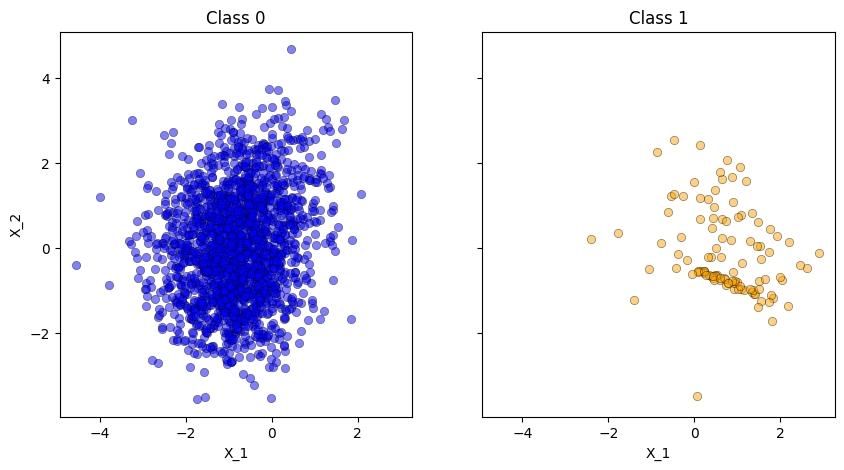

In [168]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=2,
                           weights=[0.95, 0.05],
                           class_sep=0.8, random_state=42, hypercube = True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)
sns.scatterplot(x = X[y==0][:,0], y = X[y==0][:,1], alpha = 0.5, ax = ax1, edgecolor="k", c = 'blue')
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Class 0')
sns.scatterplot(x = X[y==1][:,0], y = X[y==1][:,1], alpha = 0.5, ax = ax2, edgecolor="k", c = 'orange')
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('Class 1');

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

- We will test performance of different sampler via a specific classifier

In [170]:
model = HistGradientBoostingClassifier # LogisticRegression, RandomForestClassifier, HistGradientBoostingClassifier

In [171]:
def sort_nunique(x):
    return x[-1]

major_class, major_cnt = sorted(Counter(y_train).items(), key = sort_nunique, reverse=True)[0]
minor_class, minor_cnt = sorted(Counter(y_train).items(), key = sort_nunique, reverse=True)[-1]
X_train_major, y_train_major = X_train[y_train == major_class], y_train[y_train == major_class]
X_train_minor = X_train[y_train != major_class]

In [172]:
print('Number of major class sample:', major_cnt, '| Number of minor class sample:', minor_cnt)

Number of major class sample: 1514 | Number of minor class sample: 86


In [173]:
def SMOTE(X, n, k = 10):
    def resample(x_i, X ,indices, N):
        for i in range(N):
            i_nn = random.choice(indices)
            x_nn = X[i_nn].reshape(-1, X.shape[1])
            gap = random.uniform(0, 1)
            if i == 0:
                x_resample = x_i + gap * (x_nn - x_i)
            else:
                x_resample = np.concatenate((x_resample, x_i + gap * (x_nn - x_i)), axis=0)
        return x_resample
    T = X.shape[0]
    N = int(n/T)
    nrnb = NearestNeighbors(n_neighbors = k + 1 ,metric = 'minkowski', p = 2).fit(X)
    for idx, x in enumerate(X_train_minor):
        x = x.reshape((-1, X_train_minor.shape[1]))
        indices = nrnb.kneighbors(x,  return_distance=False).squeeze().tolist()[1:]
        if idx == 0:
            X_resample = resample(x, X, indices, N)
        else:
            X_resample = np.concatenate((X_resample, resample(x, X, indices, N)), axis=0)
    return X_resample

X_train_minor_resample = SMOTE(X_train_minor, major_cnt, k = 5)
y_train_minor_resample = np.array([minor_class for i in range(len(X_train_minor_resample))])
X_train_resample = np.concatenate((X_train_major,X_train_minor_resample), axis=0)
y_train_resample = np.concatenate((y_train_major,y_train_minor_resample), axis=0)

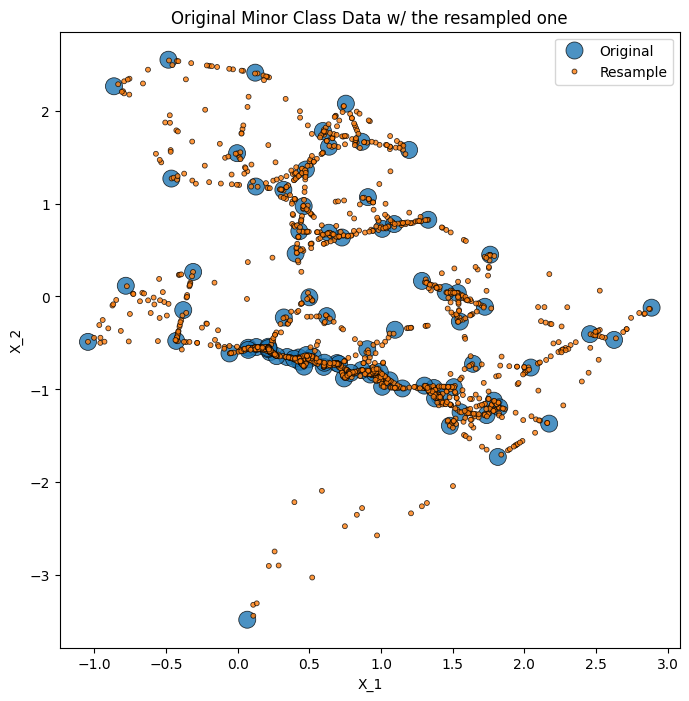

In [174]:
X_train_minor_combine = np.concatenate((X_train_minor,X_train_minor_resample), axis=0)
y_train_minor_combine = np.array(['Original' for i in range(minor_cnt)] + ['Resample' for i in range(len(X_train_minor_resample))])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x = X_train_minor_combine[:,0], y = X_train_minor_combine[:,1], hue = y_train_minor_combine, alpha = 0.8, ax = ax, edgecolor="k", size = y_train_minor_combine, style = y_train_minor_combine, sizes = [150,50], markers = ['o', '.'])
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_title('Original Minor Class Data w/ the resampled one');

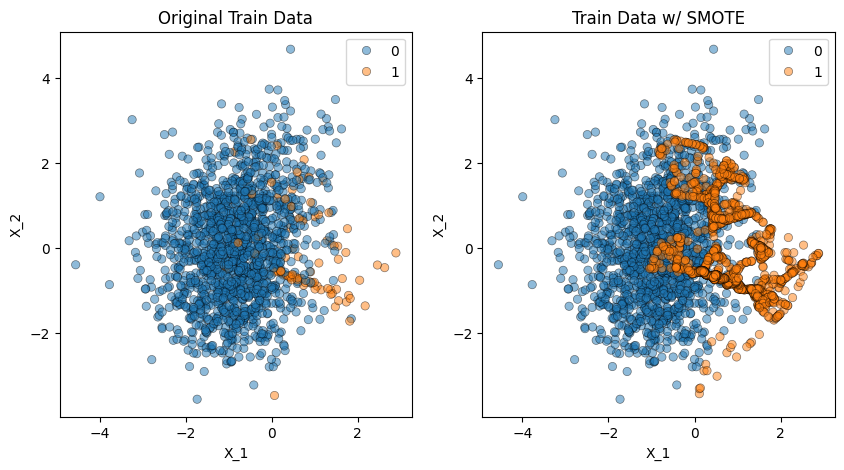

In [175]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = y_train, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Original Train Data')
sns.scatterplot(x = X_train_resample[:,0], y = X_train_resample[:,1], hue = y_train_resample, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('Train Data w/ SMOTE');

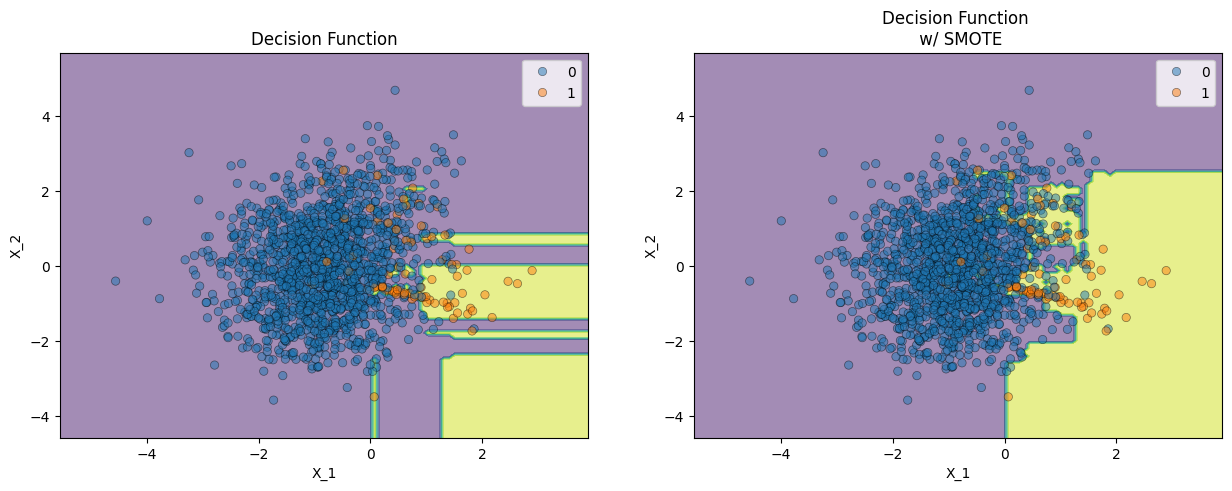

In [176]:
clf = model()
clf.fit(X_train, y_train)
clf_w_resample = model()
clf_w_resample.fit(X_train_resample, y_train_resample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

DecisionBoundaryDisplay.from_estimator(
    clf, X_train, response_method="predict",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax1
)
DecisionBoundaryDisplay.from_estimator(
    clf_w_resample, X_train, response_method="predict",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax2
)
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = y_train, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_title('Decision Function')
sns.scatterplot(x = X_train[:,0], y = X_train[:,1], hue = y_train, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_title('Decision Function \n w/ SMOTE');

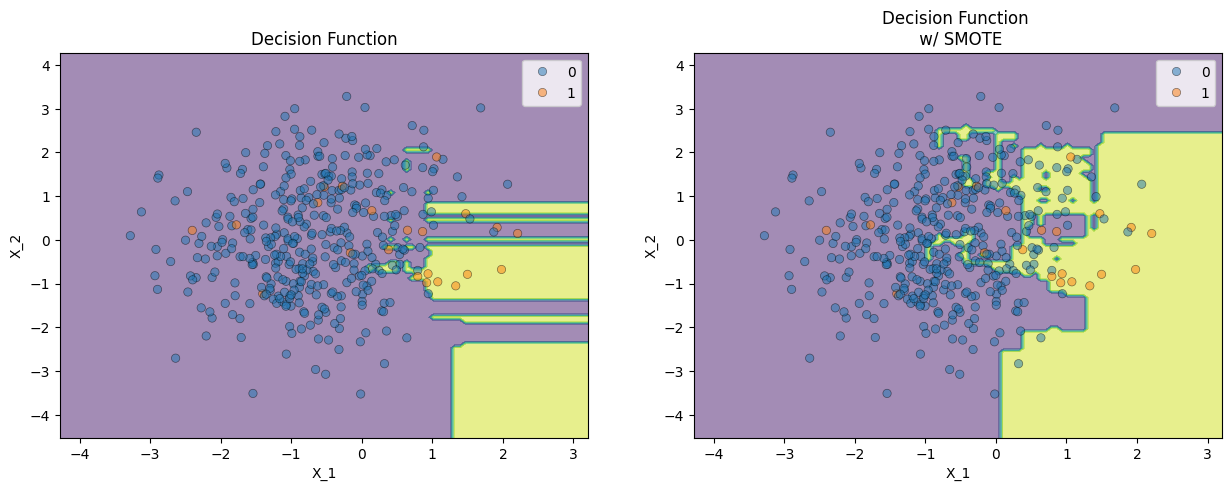

In [177]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

DecisionBoundaryDisplay.from_estimator(
    clf, X_test, response_method="predict",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax1
)
DecisionBoundaryDisplay.from_estimator(
    clf_w_resample, X_test, response_method="predict",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax2
)
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = y_test, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_title('Decision Function')
sns.scatterplot(x = X_test[:,0], y = X_test[:,1], hue = y_test, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_title('Decision Function \n w/ SMOTE');

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1514
           1       0.98      0.95      0.96        86

    accuracy                           1.00      1600
   macro avg       0.99      0.98      0.98      1600
weighted avg       1.00      1.00      1.00      1600

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1514
           1       0.50      0.94      0.65        86

    accuracy                           0.95      1600
   macro avg       0.75      0.94      0.81      1600
weighted avg       0.97      0.95      0.95      1600



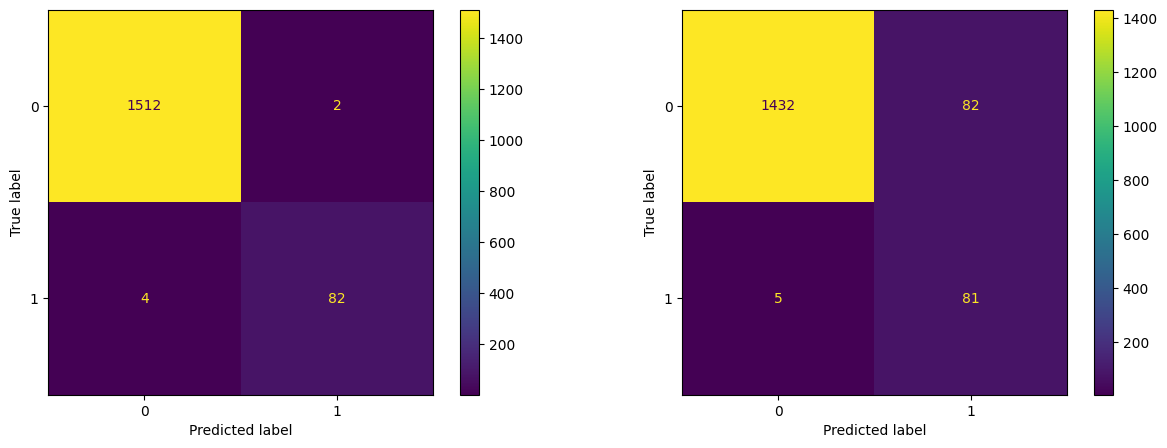

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf,X_train,y_train, ax = ax1)
### 
y_train_pred = clf_w_resample.predict(X_train)
print(classification_report(y_train, y_train_pred))
cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf_w_resample,X_train,y_train, ax = ax2)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       378
           1       0.50      0.36      0.42        22

    accuracy                           0.94       400
   macro avg       0.73      0.67      0.70       400
weighted avg       0.94      0.94      0.94       400

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       378
           1       0.20      0.64      0.31        22

    accuracy                           0.84       400
   macro avg       0.59      0.75      0.61       400
weighted avg       0.93      0.84      0.88       400



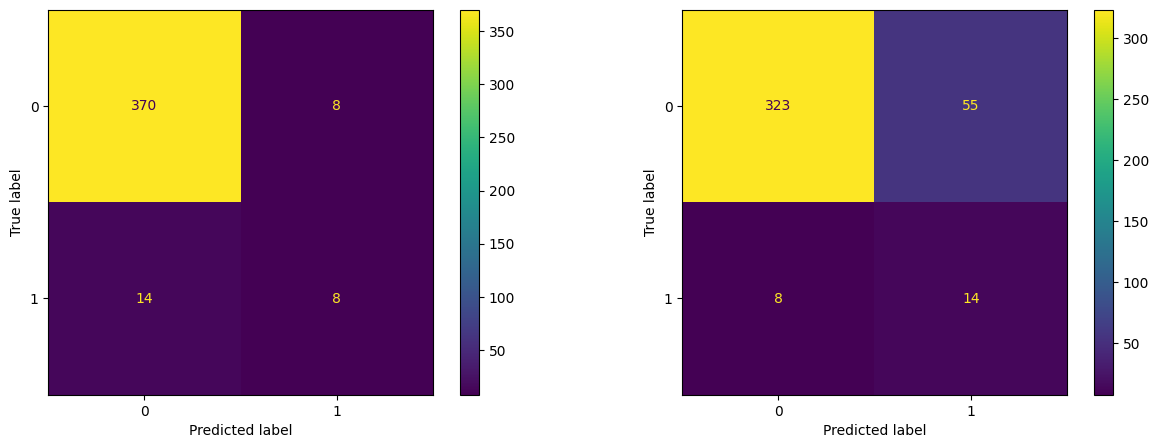

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test, ax = ax1)
### 
y_test_pred = clf_w_resample.predict(X_test)
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf_w_resample,X_test,y_test, ax = ax2)